# Setting the environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Setup

Installing libraries.

In [ ]:
!pip install transformers
!pip install nltk==3.6.1
!pip install tqdm==4.61.0
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

     |████████████████████████████████| 2.3MB 13.3MB/s 
     |████████████████████████████████| 901kB 50.5MB/s 
     |████████████████████████████████| 3.3MB 47.2MB/s 
     |████████████████████████████████| 1.5MB 13.3MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 81kB 6.8MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-7436ixdf
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-7436ixdf
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 645kB 13.1MB/s 
     |████████████████████████████████| 27

Now we are going to import the libraries.

In [ ]:
# importing libraries
import string
import re
import os
from typing import *
import math
import random
import pickle

import json
import xml.etree.ElementTree as ET

from tqdm import tqdm
from pprint import pprint

#Numpy
import numpy as np

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

#Transformers
from transformers import BertTokenizer, BertModel, AdamW

#PL
import pytorch_lightning as pl

#NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

#PLT
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


We fix the seed in order to obtain reproducible executions.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We set the device on which load the data and the model.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
device

'cuda'

We set the path of the working space and the files.

In [ ]:
ROOT = 'drive/MyDrive/Colab_Notebooks/NLP_HW3/'

semcor_data_path = ROOT + 'WSD_Evaluation_Framework/Training_Corpora/SemCor/semcor.data.xml'
semcor_gold_key_path = ROOT + 'WSD_Evaluation_Framework/Training_Corpora/SemCor/semcor.gold.key.txt'

semeval2007_data_path = ROOT + 'WSD_Evaluation_Framework/Evaluation_Datasets/semeval2007/semeval2007.data.xml'
semeval2007_gold_key_path = ROOT + 'WSD_Evaluation_Framework/Evaluation_Datasets/semeval2007/semeval2007.gold.key.txt'


wic_train_path = ROOT + 'wic_data/train.jsonl'

wic_dev_path = ROOT + 'wic_data/dev.jsonl'
wic_dev_gold_key_path = ROOT + 'wic_data/dev_wsd.txt'

#Data

##Pre-Processing

In this section we are performing the pre-processing step for the sentences. 

In [ ]:
# random string used for highlight the target word and perform pre-processing without care 
# about the change position of the target word 
TARGET_HIGHLIGHTER = 'iardyzywdgjglbwpvmwp'

# adding the highlighter befor the target word
def add_highlighter_target_word(sentence: str, start_target_word: int):
    return sentence[:start_target_word] + TARGET_HIGHLIGHTER + sentence[start_target_word:]

# removing the highlighter 
def remove_highlighter_target_word(sentence: str):
    return sentence.replace(TARGET_HIGHLIGHTER, '')

# removing punctuation and multiple spaces
def remove_punctuation(sentence: str):
    
    sentence = sentence.replace(chr(8221), ' ') # ”
    sentence = sentence.replace(chr(8220), ' ') # “
    sentence = sentence.replace(chr(8212), ' ') # —
    sentence = sentence.replace(chr(8211), ' ') # –
    sentence = sentence.replace(chr(8208), ' ') # ‐
    
    sentence = sentence.replace(chr(8216), '') # ‘
    sentence = sentence.replace(chr(8217), '') # ’
    sentence = sentence.replace(chr(39), '') # '

    for punc in string.punctuation:
        sentence = sentence.replace(punc, ' ')

    sentence = re.sub(' +', ' ', sentence)

    return sentence

# removing stopwords
def remove_stopwords(sentence: str):
    sentence_without_stopwords = ''
    stopWords = set(stopwords.words('english'))
    for word in sentence.split(' '):
        if word not in stopWords:
            sentence_without_stopwords += (word + ' ')
    return sentence_without_stopwords.strip()

# retriving the position of the target word after the preprocessing based on the highlighter
def get_index_target_word(sentence: str):
    i = 0
    for word in sentence.split(' '):
        if TARGET_HIGHLIGHTER in word:
            return i
        else:
            i += 1

# pre-processing the sentence returning the clean sentence,
# the number of words in the sentence, 
# and the position of the target word
def preprocess_sentence(sentence: str, start_target_word: int, preprocess: bool):
    sentence = add_highlighter_target_word(sentence, start_target_word)
    if preprocess == True:
        sentence = sentence.strip()
        sentence = sentence.lower()
        sentence = remove_punctuation(sentence)
        sentence = remove_stopwords(sentence)
        sentence = sentence.strip()
    index_target_word = get_index_target_word(sentence)
    sentence = remove_highlighter_target_word(sentence)
    n_words = sentence.count(' ')+1
    return sentence, n_words, index_target_word

# pre-processing the definition returning the clean definition
def preprocess_definition(sentence: str, preprocess: bool):
    sentence = sentence.strip()
    if preprocess == True:    
        sentence = sentence.lower()
        sentence = remove_punctuation(sentence)
        sentence = remove_stopwords(sentence)
        sentence = sentence.strip()
    return sentence

##Dataset WSD

In [ ]:
# dictionary for pos-tag
# pos tag string -> wordnet pos tag
pos_dict = {
    'NOUN': wn.NOUN,
    'VERB': wn.VERB,
    'ADJ': wn.ADJ,
    'ADV': wn.ADV
}

We are going to define the SemcorDataset class.

In [ ]:
class SemcorDataset(torch.utils.data.Dataset):

    def __init__(self, 
                 dataset_path1: str, 
                 dataset_path2: str,
                 n_target_words: int,
                 weak_supervision = True,
                 preprocess = True,
                 device = 'cuda'):

        # device
        self.device = device

        # parameters to generate the context_sentences
        self.weak_supervision = weak_supervision
        self.preprocess = preprocess

        # path of the files
        self.dataset_path = (dataset_path1, dataset_path2)

        # retrieving the data from the input files
        raw_data = self._init_data(n_target_words)

        # peforming pre-processing steps and generating the context_sentences from the raw data
        processed_data = self._process_data(raw_data)

        # bert tokenizer to tokenize sentences
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        # tokenizing the context_sentences from the processed_data
        self.data = self._tokenize_data(processed_data, tokenizer)
        

    def _init_data(self, n_target_words):
        
        # opening the file of the gold key sense
        with open(self.dataset_path[1]) as f:
            lines = f.readlines()

        # dict that associate the id of the sentence to the gold key sense
        # id -> gold key sense
        self.id2gold_key_sense = {} 
        for line in lines:
            line = line.replace('\n', '').split(' ')
            self.id2gold_key_sense[line[0]] = line[1]
        
        raw_data = []
        
        # opening xml file
        root = ET.parse(self.dataset_path[0]).getroot()
        sentence_items = root.findall(".//sentence")
        
        # for each sentence_item in the corpus
        for sentence_item in tqdm(sentence_items):
            
            # put the sentence together
            sentence = ''
            for word_item in sentence_item:
                sentence += word_item.text + ' '
            sentence = sentence.strip()
            
            # for each sentence I consider the same sentence multiple times
            # for each targat-word in it
            i = 0
            for index, word_item in enumerate(sentence_item):

                if word_item.tag == 'instance':
                    record = (
                        sentence, 
                        index, 
                        word_item.attrib['lemma'],
                        word_item.attrib['pos'], 
                        word_item.attrib['id'], 
                        self.id2gold_key_sense[word_item.attrib['id']],
                        )
                    raw_data.append(record)
                    i += 1

                # I consider at most n_target_words for each sentence_item
                if i == n_target_words:
                    break
        
        # return raw_data
        return raw_data

    def _process_data(self, raw_data):
        
        processed_data = []

        # for each sentence record in the raw data
        for sentence, index_target_word, lemma_target_word, pos, id, label_sense in tqdm(raw_data):
            
            # performing pre-processing steps and getting the index of the target-word in the sentence

            sentence_splitted = sentence.split(' ')

            start_target_word = 0
            for w in sentence_splitted[0:index_target_word]:
                start_target_word += (len(w) + 1)

            sentence, _, index_target_word = preprocess_sentence(sentence, 
                                                                 start_target_word,
                                                                 self.preprocess)
            
            # surrounding the target word with the highlighter "
            sentence_splitted = sentence.split(' ')
            target_word = sentence_splitted[index_target_word]
            # " -> id 1000
            sentence_splitted[index_target_word] = '"' + sentence_splitted[index_target_word] + '"' 
            sentence = ' '.join(w for w in sentence_splitted)

            # retrieving all the senses of the lemma of the target word from wordnet
            target_word_senses = wn.lemmas(lemma_target_word, pos=pos_dict[pos])    
            
            # for each sense for the target word
            for target_word_sense in target_word_senses:
                
                # get the gloss of the sense
                definition = target_word_sense.synset().definition()
                
                # get the key of the sense
                key = target_word_sense.key()
                
                # generating the context_sentence
                context_sentence = '[CLS] ' + sentence + ' [SEP] ' 
                
                if self.weak_supervision == True:
                    context_sentence += lemma_target_word + ' : '  
                
                context_sentence += preprocess_definition(definition, self.preprocess) + ' [SEP] '
                
                # setting the label
                label = (label_sense == key)

                # appending the record in processed_data
                processed_data.append(
                    (context_sentence, 
                     id, 
                     label, 
                     key)
                )
                
        # returning the processes_data
        return processed_data

    def _tokenize_data(self, processed_data, tokenizer):

        data = []

        # for each context_sentence
        for context_sentence, id, label, key in tqdm(processed_data):
            
            # tokenize the context_sentence with the bert tokenizer
            tokenized_sentence = tokenizer.tokenize(context_sentence)

            # converting the tonkens to ids (number)
            indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_sentence)

            # get the index of the first [SEP] token
            index_SEP = indexed_tokens.index(102)

            # get the index of the " surrounding the target-word
            index_1000_1 = indexed_tokens.index(1000)
            index_1000_2 = indexed_tokens.index(1000, index_1000_1+1)

            # the the index of the first and the last token corresponding to the target-word
            index_target_word_start = index_1000_1 + 1
            index_target_word_end = index_1000_2 - 1

            if self.weak_supervision == False:
                del indexed_tokens[index_1000_2]
                del indexed_tokens[index_1000_1]
                index_SEP -= 2
                index_target_word_start -= 1
                index_target_word_end -= 1

            # tensor the tokens
            tokens = torch.tensor(indexed_tokens, device=self.device)

            # appending the record to data
            data.append({
                'tokens':tokens, 
                'len':len(tokens), 
                'index_SEP':index_SEP, 
                'index_target_word_start':index_target_word_start, 
                'index_target_word_end':index_target_word_end, 
                'id':id, 
                'label':label, 
                'key':key
            })

        # returning data
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

##Dataset WiC

We are going to define the dataset class for the WiC task. It is equal to the previous dataset, but the data are taken from the jsnol file. 

In [ ]:
class WiCTestDataset(torch.utils.data.Dataset):

    def __init__(self, 
                 dataset_path1: str, 
                 dataset_path2: str, 
                 weak_supervision = True,
                 preprocess = True,
                 device = 'cuda'):

        self.device = device

        self.dataset_path = (dataset_path1, dataset_path2)
        self.preprocess = preprocess
        
        self.weak_supervision = weak_supervision

        raw_data = self._init_data()

        processed_data = self._process_data(raw_data)

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.data = self._tokenize_data(processed_data, tokenizer)

    def _init_data(self):

        with open(self.dataset_path[1]) as f:
            lines = f.readlines()

        #id_sentence -> gold key sense
        self.id_sentence2gold_key_sense = {} 

        for line in lines:
            line = line.replace('\n', '').split(' ')
            self.id_sentence2gold_key_sense[line[0]] = line[1]

        #id_instance (sentence pair) -> T/F
        self.id_instance2gold_label = {} 

        raw_data = []
        
        with open(self.dataset_path[0]) as f:
        
            json_list = list(f)
        
            for json_str in tqdm(json_list):

                line = json.loads(json_str)

                id = line['id']
                lemma_target_word = line['lemma']
                pos = line['pos']

                sentence1 = line['sentence1']
                sentence2 = line['sentence2']
                start1, end1 = int(line['start1']), int(line['end1'])
                start2, end2 = int(line['start2']), int(line['end2'])

                label = True if line['label'] == 'True' else False

                self.id_instance2gold_label[id] = label

                raw_data.append(
                    (id+'.s1', sentence1, start1, lemma_target_word, pos, self.id_sentence2gold_key_sense[id+'.s1'])
                )

                raw_data.append(
                    (id+'.s2', sentence2, start2, lemma_target_word, pos, self.id_sentence2gold_key_sense[id+'.s2'])
                )   

        return raw_data

    def _process_data(self, raw_data):

        processed_data = []

        for id_sentence, sentence, start_target_word, lemma_target_word, pos, label_sense in tqdm(raw_data):

            sentence, _, index_target_word = preprocess_sentence(sentence, 
                                                                 start_target_word,
                                                                 self.preprocess)

            sentence_splitted = sentence.split(' ')

            target_word = sentence_splitted[index_target_word]
            # " -> id 1000
            sentence_splitted[index_target_word] = '"' + sentence_splitted[index_target_word] + '"'
            
            sentence = ' '.join(w for w in sentence_splitted)

            target_word_senses = wn.lemmas(lemma_target_word, pos=pos_dict[pos])

            for target_word_sense in target_word_senses:
                
                definition = target_word_sense.synset().definition()
                key = target_word_sense.key()
                
                context_sentence = '[CLS] ' + sentence + ' [SEP] ' 
                
                if self.weak_supervision == True:
                    context_sentence += lemma_target_word + ' : '  
                
                context_sentence += preprocess_definition(definition, self.preprocess) + ' [SEP] '

                label = (label_sense == key)
                
                processed_data.append(
                    (context_sentence, 
                     id_sentence, 
                     label, 
                     key)
                )
                
        return processed_data

    def _tokenize_data(self, processed_data, tokenizer):

        data = []

        for context_sentence, id_sentence, label, key in tqdm(processed_data):

            tokenized_sentence = tokenizer.tokenize(context_sentence)

            indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_sentence)

            index_SEP = indexed_tokens.index(102)

            index_1000_1 = indexed_tokens.index(1000)
            index_1000_2 = indexed_tokens.index(1000, index_1000_1+1)

            index_target_word_start = index_1000_1 + 1
            index_target_word_end = index_1000_2 - 1

            if self.weak_supervision == False:
                del indexed_tokens[index_1000_2]
                del indexed_tokens[index_1000_1]
                index_SEP -= 2
                index_target_word_start -= 1
                index_target_word_end -= 1

            tokens = torch.tensor(indexed_tokens, device=self.device)

            data.append({
                'tokens':tokens, 
                'len':len(tokens), 
                'index_SEP':index_SEP, 
                'index_target_word_start':index_target_word_start, 
                'index_target_word_end':index_target_word_end, 
                'id':id_sentence, 
                'label':label, 
                'key':key
            })

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

##Collate function

We are going to define the collate function for batching the data.

In [ ]:
def collate_fn(
    samples: List[Dict]
):
    tokens = [sample['tokens'] for sample in samples] # tokens of the contenxt_sentences
    lens = [sample['len'] for sample in samples] # lenghts of the contenxt_sentences
    index_SEPs = [sample['index_SEP'] for sample in samples] # the positions of the first [SEP] token in the contenxt_sentences
    index_target_word_starts = [sample['index_target_word_start'] for sample in samples] # the positions of the first token corresponding to the target-word in the contenxt_sentences
    index_target_word_ends = [sample['index_target_word_end'] for sample in samples] # the positions of the last token corresponding to the target-word in the contenxt_sentences
    ids = [sample['id'] for sample in samples] # ids of the contenxt_sentences
    labels = [np.float32(sample['label']) for sample in samples] # the labels of the context_sentences w.r.t. the sense keys
    keys = [sample['key'] for sample in samples] # the sense keys of the contenxt_sentences

    # pad with 0 the tokens of the sentences
    tokens = torch.nn.utils.rnn.pad_sequence(tokens, batch_first=True, padding_value=0)

    lens = torch.tensor(lens, device=device)

    index_SEPs = torch.tensor(index_SEPs, device=device)

    index_target_word_starts = torch.tensor(index_target_word_starts, device=device)

    index_target_word_ends = torch.tensor(index_target_word_ends, device=device)

    labels = torch.tensor(labels, device=device)

    # return a dictionary 
    return {
        'tokens':tokens, 
        'lens':lens, 
        'index_SEPs':index_SEPs, 
        'index_target_word_starts':index_target_word_starts, 
        'index_target_word_ends':index_target_word_ends, 
        'ids':ids, 
        'labels':labels, 
        'keys':keys
        }        

Model

##WSDModel

We are going to define the pytorch model.

In [ ]:
class WSDModel(nn.Module):
    
    def __init__(self, 
                 retrieve_token_fn, 
                 p_dropout):
        
        super(WSDModel, self).__init__()
        
        # bert pre-trained model 
        self.bert = BertModel.from_pretrained(
            'bert-base-uncased',
            output_hidden_states = True).to(device)

        # function to retrieve the tokens of interest to feed the classifier
        self.retrieve_token_fn = retrieve_token_fn
        
        # linear layers
        self.lin1 = torch.nn.Linear(768, 384)
        self.lin2 = torch.nn.Linear(384, 1)

        # dropout layer
        self.dropout = torch.nn.Dropout(p=p_dropout)
    
    def forward(self, 
                tokens: torch.Tensor, 
                lens: torch.Tensor,
                index_SEP: torch.Tensor, 
                index_target_word_starts: torch.Tensor, 
                index_target_word_ends: torch.Tensor):

        #print('tokens.shape:', tokens.shape)
        #print('tokens:', tokens)
        
        #print('index_SEP.shape:', index_SEP.shape)
        #print('index_SEP:', index_SEP)

        #print('index_target_word_starts.shape:', index_target_word_starts.shape)
        #print('index_target_word_starts:', index_target_word_starts)

        #print('index_target_word_ends.shape:', index_target_word_ends.shape)
        #print('index_target_word_ends:', index_target_word_ends)

        #print('lens.shape:', lens.shape)
        #print('lens:', lens)

        #if y is not None:
            #print('y.shape:', y.shape)
            #print('y:', y)

        # get the shape of the batched tokens
        batch_size, seq_len = tokens.shape

        # generating the attention mask for bert model
        attention_masks = [[1]*len_ + [0]*(seq_len-len_) for len_ in lens]
        attention_masks = [torch.tensor(attention_mask, device=device) for attention_mask in attention_masks]
        attention_masks = torch.stack(attention_masks)

        #print('attention_masks.shape:', attention_masks.shape)
        #print('attention_masks', attention_masks)

        # generating the segments ids for bert model
        segments = [([0]*(index_SEP_+1)) + ([1]*(seq_len-index_SEP_-1)) for index_SEP_ in index_SEP]
        segments = [torch.tensor(segment, device=device) for segment in segments]
        segments = torch.stack(segments)

        #print('segments.shape:', segments.shape)
        #print('segments:', segments)

        # model the tokens with bert
        bert_embeddings = self.bert(input_ids=tokens, 
                                    attention_mask=attention_masks,
                                    token_type_ids=segments,
                                    )

        # obtaining bert hidden_states
        hidden_states = bert_embeddings[2]
        token_embeddings = torch.stack(hidden_states, dim=0)
        # token_embeddings.shape = n_hidden x batch_size x seq_len x hidden_dim
        #print('token_embeddings.shape:', token_embeddings.shape)

        # get the hidden state of the last layer of bert
        last_hidden_embeddings = token_embeddings[-1]
        # last_hidden_embeddings.shape = batch_size x seq_len x hidden_dim
        #print('last_hidden_embeddings.shape:', last_hidden_embeddings.shape)

        # obtaining the tokens of interest to feed the classifier
        last_hidden_token_embeddings = self.retrieve_token_fn(last_hidden_embeddings, 
                                                              index_target_word_starts,
                                                              index_target_word_ends)
        # last_hidden_token_embeddings.shape = batch x hidden_dim
        #print('last_hidden_token_embeddings.shape:', last_hidden_token_embeddings.shape)
        
        # first linear layer
        out = self.lin1(last_hidden_token_embeddings)
        #print('output lin1.shape', out.shape)

        # ReLU
        out = torch.relu(out)
        #print('output relu.shape', out.shape)

        # dropout layer
        out = self.dropout(out)
        #print('output dropout.shape', out.shape)

        # second linear layer
        out = self.lin2(out)
        #print('output lin2.shape', out.shape)
        
        out = out.squeeze(1)
        #print('output squeeze.shape', out.shape)

        # Sigmoid
        out = torch.sigmoid(out)
        #print('output sigmoid.shape', out.shape)

        #print('out:', out)
        
        # return the output of the model
        return out

###Retrieve function

Here we are going to define the functions to retrieve the tokens of interest to feed the classifier.

In [ ]:
# get for each element in the batch, the first embedding 
# (the one corresponding to the first [CLS] token in the context_sentence)
def get_CLS_embedding(last_hidden_embeddings, a, b):
    return last_hidden_embeddings[:, 0, :]

# get for each element in the batch, the average of the tokens
# corresponding to the target-word tokens
def get_target_word_embedding(last_hidden_embeddings, 
                              index_target_word_starts, 
                              index_target_word_ends):

    averaged_target_token_embedding = []

    batch_size, _, _ = last_hidden_embeddings.shape

    for i in range(batch_size):
        index_target_word_start = index_target_word_starts[i]
        index_target_word_end = index_target_word_ends[i]
        cur = last_hidden_embeddings[i][index_target_word_start:index_target_word_end+1]
        cur = torch.mean(cur, dim=0)
        averaged_target_token_embedding.append(cur)

    averaged_target_token_embedding = torch.stack(averaged_target_token_embedding)

    return averaged_target_token_embedding

#PL

##Data module

Here we are going to define the datamodule.

In [ ]:
class DataModuleWSD(pl.LightningDataModule):
    def __init__(self, 
                 training_file, 
                 dev_file, 
                 test_file, 
                 n_target_words,
                 weak_supervision,
                 preprocess,
                 batch_size,
                 device):
        
        super().__init__()

        # path of the files
        self.training_file = training_file
        self.dev_file = dev_file
        self.test_file = test_file

        # number of target words to consider in each sentence item
        self.n_target_words = n_target_words

        # using or not the signals to highlight the target-word in the context_sentence
        self.weak_supervision = weak_supervision

        # perform or not the pre-processing steps
        self.preprocess = preprocess

        # batch size
        self.batch_size = batch_size

        # device
        self.device = device

    def setup(self, stage: Optional[str] = None) -> None:
        
        # when we are fitting the model we use both training set and dev dataset

        if stage == 'fit':

            self.trainingset = SemcorDataset(self.training_file[0], self.training_file[1],
                                             self.n_target_words,
                                             self.weak_supervision,
                                             self.preprocess,
                                             self.device)
        
            print('Len training set:', len(self.trainingset))
        
            self.devset = SemcorDataset(self.dev_file[0], self.dev_file[1],  
                                        float('inf'),
                                        self.weak_supervision,
                                        self.preprocess,
                                        self.device)

            print('Len dev set:', len(self.devset))

        # when we are testing the model we use only the test dataset

        elif stage == 'test':

            self.testset = WiCTestDataset(self.test_file[0], self.test_file[1],
                                          self.weak_supervision,
                                          self.preprocess,
                                          self.device)
        
            print('Len test set:', len(self.testset))
                                        
    
    # dataloaders

    def train_dataloader(self):
        return DataLoader(self.trainingset,
                          batch_size=self.batch_size,
                          collate_fn=collate_fn)
    
    def val_dataloader(self):
        return DataLoader(self.devset, 
                          batch_size=self.batch_size,
                          collate_fn=collate_fn)
    
    def test_dataloader(self):
        return DataLoader(self.testset, 
                          batch_size=self.batch_size,
                          collate_fn=collate_fn)

##WSDModelPL

We are going to define the pytorch-lighning model.

In [ ]:
class WSDModelPL(pl.LightningModule):

    def __init__(self, hparams, *args, **kwargs):
        super(WSDModelPL, self).__init__(*args, **kwargs)

        # learning rate of the optimizer
        self.lr = hparams['lr']

        self.save_hyperparameters(hparams)

        # instantiating the pytorch WSDModel
        self.model = WSDModel(retrieve_token_fn=hparams['retrieve_token_fn'],
                              p_dropout=hparams['p_dropout'])

        # BCEloss function 
        self.loss_fn = torch.nn.BCELoss()

    # computing the forward
    def forward(self, 
                tokens: torch.Tensor, 
                lens: torch.Tensor,
                index_SEPs: torch.Tensor, 
                index_target_word_starts: torch.Tensor, 
                index_target_word_ends: torch.Tensor):
        
        # get the output of the model
        out = self.model(tokens, 
                         lens, 
                         index_SEPs, 
                         index_target_word_starts, index_target_word_ends)
        
        # return the output of the model
        return out


    # TRAINING

    def training_step(self, batch, batch_nb):

        # retrieving the inputs from the batch
        tokens = batch['tokens']
        lens = batch['lens']
        index_SEPs = batch['index_SEPs']
        index_target_word_starts = batch['index_target_word_starts']
        index_target_word_ends = batch['index_target_word_ends']
        labels = batch['labels']

        # computing the forward
        out = self.forward(tokens, 
                              lens, 
                              index_SEPs, 
                              index_target_word_starts, index_target_word_ends)
        
        # computing the loss
        loss = self.loss_fn(out, labels)

        self.log('train_loss', loss, prog_bar=True)

        # returning the loss
        return loss


    # VALIDATION

    def validation_step(self, batch, batch_nb):

        # retrieving the inputs from the batch
        tokens = batch['tokens']
        lens = batch['lens']
        index_SEPs = batch['index_SEPs']
        index_target_word_starts = batch['index_target_word_starts']
        index_target_word_ends = batch['index_target_word_ends']
        ids = batch['ids']
        keys = batch['keys']
        labels = batch['labels']

        # computing the forward
        out = self.forward(tokens, 
                              lens, 
                              index_SEPs, 
                              index_target_word_starts, index_target_word_ends)
        
        # computing the loss
        #loss = self.loss_fn(out, labels)

        sample_loss = self.loss_fn(out, labels)

        self.log('valid_loss', sample_loss, prog_bar=True)

        # return the ids, the probability and the keys computed for the inputs
        return (ids, out, keys)

    # when a validation epoch ends
    def validation_epoch_end(self, validation_step_outputs):
        
        ids_sentence, probs, keys = [], [], []

        # retrieving all the computed outputs for each batch
        for validation_step_output in validation_step_outputs:
            ids_sentence.extend(validation_step_output[0])
            probs.extend(validation_step_output[1])
            keys.extend(validation_step_output[2])


        # dictionary that associate the predictions of the model to a sentence id
        # each prediction is composed by the sense key and the probability 
        # id_sentence -> List[(probability, key)]
        id_sentence2predictions = {}

        for id_sentence, prob, key in zip(ids_sentence, probs, keys):
            if id_sentence not in id_sentence2predictions.keys():
                id_sentence2predictions[id_sentence] = [(prob, key)] 
            else:
                id_sentence2predictions[id_sentence].append(
                    (prob,key)
                )
        
        n, n_corrected_senses = 0, 0 

        for id_sentence in id_sentence2predictions:
            
            # get all the predictions for the sentence id_sentence
            pred_list = id_sentence2predictions[id_sentence]
            
            # get all the probability from the list of predictions
            probs = [prob for prob, _ in pred_list]

            # get the index with the highest probability
            pred = np.argmax(probs)

            # get the sense key corresponding to the highest probability
            pred_key_sense = pred_list[pred][1]
            gold_key_sense = WSDeWiCDataModule.devset.id2gold_key_sense[id_sentence]

            # computing the number of predictions performed and the number of predicted senses that are correct
            n += 1
            n_corrected_senses += (pred_key_sense == gold_key_sense)

        # computing the accuracy
        accuracy = n_corrected_senses/n

        self.log('valid_accuracy', accuracy, prog_bar=True)


    # TEST        

    def test_step(self, batch, batch_nb):
        
        # retrieving the inputs from the batch
        tokens = batch['tokens']
        lens = batch['lens']
        index_SEPs = batch['index_SEPs']
        index_target_word_starts = batch['index_target_word_starts']
        index_target_word_ends = batch['index_target_word_ends']
        ids_sentence = batch['ids']
        keys = batch['keys']
        labels = batch['labels']

        # computing the forward
        out = self.forward(tokens, 
                              lens, 
                              index_SEPs, 
                              index_target_word_starts, index_target_word_ends)
        
        # computing the loss
        loss = self.loss_fn(out, labels)

        sample_loss = self.loss_fn(out, labels)
        
        # return the ids, the probability and the keys computed for the inputs
        return (ids_sentence, out, keys)
    
    def test_epoch_end(self, test_step_outputs):

        ids_sentence, probs, keys = [], [], []

        # retrieving all the computed outputs for each batch
        for test_step_output in test_step_outputs:
            ids_sentence.extend(test_step_output[0])
            probs.extend(test_step_output[1])
            keys.extend(test_step_output[2])

        # dictionary that associate the predictions of the model to a sentence id
        # each prediction is composed by the sense key and the probability 
        # id_sentence -> List[(probability, key)]
        id_sentence2predictions = {}

        for id_sentence, prob, key in zip(ids_sentence, probs, keys):
            if id_sentence not in id_sentence2predictions.keys():
                id_sentence2predictions[id_sentence] = [(prob, key)] 
            else:
                id_sentence2predictions[id_sentence].append(
                    (prob,key)
                )
    

        # dictionary that associate the predicted key sense of the model to a sentence id
        # the predicted key sense is the key sense with the highest probability
        # id_sentence -> predicted_key_sense
        id_sentence2predicted_key_sense = {} #id_sentence -> predicted key sense

        # computing the predicted sense key from all the predictions
        for id_sentence in id_sentence2predictions:
            
            # get all the predictions for the sentence id_sentence
            pred_list = id_sentence2predictions[id_sentence]
            
            # get all the probability from the list of predictions
            probs = [prob for prob, _ in pred_list]

            # get the index with the highest probability
            pred = np.argmax(probs)

            # get the sense key corresponding to the highest probability
            pred_key_sense = pred_list[pred][1]

            # save the predicted_key_sense in the dictionary id_sentence2predicted_key_sense
            id_sentence2predicted_key_sense[id_sentence] = pred_key_sense


        # computing the number of predictions performed and the number of predicted senses that are correct for the WSD task
        # and the TP, TN, FP, FN for the WiC task
        n, n_corrected_senses = 0, 0
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for id_instance in WSDeWiCDataModule.testset.id_instance2gold_label:
            
            n += 1

            id_sentence1 = id_instance+'.s1'
            id_sentence2 = id_instance+'.s2'

            gold_sense1 = WSDeWiCDataModule.testset.id_sentence2gold_key_sense[id_sentence1]
            gold_sense2 = WSDeWiCDataModule.testset.id_sentence2gold_key_sense[id_sentence2]

            gold_label = WSDeWiCDataModule.testset.id_instance2gold_label[id_instance]

            predicted_sense1 = id_sentence2predicted_key_sense[id_sentence1]
            predicted_sense2 = id_sentence2predicted_key_sense[id_sentence2]

            predicted_label = (predicted_sense1 == predicted_sense2)


            n_corrected_senses += (predicted_sense1 == gold_sense1)
            n_corrected_senses += (predicted_sense2 == gold_sense2)

            if gold_label == True:
                if gold_label == predicted_label: # actual true, predicted true
                    TP += 1
                elif gold_label != predicted_label: # actual true, predicted false
                    FN += 1
            elif gold_label == False:
                if gold_label == predicted_label: # actual false, predicted false
                    TN += 1
                elif gold_label != predicted_label: # actual false, predicted true
                    FP += 1

        # computing the accuracy for the two tasks    
        accuracy_wsd = n_corrected_senses/(2*n)
        accuracy_wic = (TP+TN)/(TP+TN+FP+FN)

        self.log('test_accuracy_wsd', accuracy_wsd, prog_bar=True)
        self.log('test_accuracy_wic', accuracy_wic, prog_bar=True)
        self.log('TP', TP, prog_bar=False)
        self.log('TN', TN, prog_bar=False)
        self.log('FP', FP, prog_bar=False)
        self.log('FN', FN, prog_bar=False)

    # optimizer
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.lr)

#Experiments

In this section we are going to train, valid and test the models.

##Token-CLS - 1 Target word - No Pre-processing

The first experiment consider only one target-word for each sentence in SemCor. It considers the (averaged) token(s) corresponding to target word to feed the classifier.

In [ ]:
# hyper-parameter of the models
hparams = {
    'retrieve_token_fn': get_target_word_embedding,
    'p_dropout': 1e-1,
    'lr': 2e-5
}

# parameters to generate the inputs
N_TARGET_WORDS = 1
WEAK_SUPERVISION = False
PREPROCESSING = False

# data module
WSDeWiCDataModule = DataModuleWSD(
    (semcor_data_path, semcor_gold_key_path), 
    (semeval2007_data_path, semeval2007_gold_key_path), 
    (wic_dev_path, wic_dev_gold_key_path),
    N_TARGET_WORDS,
    WEAK_SUPERVISION,
    PREPROCESSING,
    batch_size=16,
    device=device
    )

# path where store the checkpoints
FOLDER = 'experiments/WSDeWiCModel/Token-CLS-1TW-NP/'

# callbeck to store the checkpoint
check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_accuracy',
    verbose=True,
    save_top_k=-1,
    mode='max',
    dirpath= ROOT + FOLDER, 
    filename='{epoch}-{valid_accuracy:.4f}'
)

# trainer PL
trainer = pl.Trainer(gpus=1 if device=='cuda' else 0, 
                     val_check_interval=1.0, 
                     max_epochs=5,
                     callbacks=[check_point_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
# PL model
model = WSDModelPL(hparams)

WSDeWiCDataModule.setup('fit')

trainer.fit(model, datamodule=WSDeWiCDataModule)

In [ ]:
WSDeWiCDataModule.setup('test')

accuracies_wic_token_CLS_1TW_NP = []
accuracies_wsd_token_CLS_1TW_NP = []

TP_TN_FP_FN_token_CLS_1TW_NP = []

model_checkpoints = os.listdir(ROOT + FOLDER)

for model_checkpoint in model_checkpoints:

    loaded_model = WSDModelPL.load_from_checkpoint(
        ROOT + FOLDER + model_checkpoint) 
    
    loaded_model.eval()
    loaded_model.freeze()

    result = trainer.test(model=loaded_model, datamodule=WSDeWiCDataModule)

    accuracies_wic_token_CLS_1TW_NP.append(result[0]['test_accuracy_wic'])
    accuracies_wsd_token_CLS_1TW_NP.append(result[0]['test_accuracy_wsd'])

    TP = result[0]['TP']
    TN = result[0]['TN']
    FP = result[0]['FP']
    FN = result[0]['FN']

    TP_TN_FP_FN_token_CLS_1TW_NP.append(
        (TP, TN, FP, FN)
    )


for i in range(len(model_checkpoints)):
    print('Epoch:', i, ' - ', 
          'Accuracy WiC:', accuracies_wic_token_CLS_1TW_NP[i], ' - ',
          'Accuracy WSD:', accuracies_wsd_token_CLS_1TW_NP[i])


100%|██████████| 901/901 [00:00<00:00, 90484.09it/s]

100%|██████████| 1802/1802 [00:00<00:00, 35200.62it/s]

100%|██████████| 8622/8622 [00:08<00:00, 1071.10it/s]


Len test set: 8622


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 123.0,
 'FP': 118.0,
 'TN': 283.0,
 'TP': 377.0,
 'test_accuracy_wic': 0.7325194478034973,
 'test_accuracy_wsd': 0.6071032285690308}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 129.0,
 'FP': 107.0,
 'TN': 294.0,
 'TP': 371.0,
 'test_accuracy_wic': 0.7380688786506653,
 'test_accuracy_wsd': 0.6198667883872986}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 131.0,
 'FP': 108.0,
 'TN': 293.0,
 'TP': 369.0,
 'test_accuracy_wic': 0.7347391843795776,
 'test_accuracy_wsd': 0.612652599811554}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 142.0,
 'FP': 99.0,
 'TN': 302.0,
 'TP': 358.0,
 'test_accuracy_wic': 0.7325194478034973,
 'test_accuracy_wsd': 0.6026636958122253}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 127.0,
 'FP': 114.0,
 'TN': 287.0,
 'TP': 373.0,
 'test_accuracy_wic': 0.7325194478034973,
 'test_accuracy_wsd': 0.5843507051467896}
--------------------------------------------------------------------------------
Epoch: 0  -  Accuracy WiC: 0.7325194478034973  -  Accuracy WSD: 0.6071032285690308
Epoch: 1  -  Accuracy WiC: 0.7380688786506653  -  Accuracy WSD: 0.6198667883872986
Epoch: 2  -  Accuracy WiC: 0.7347391843795776  -  Accuracy WSD: 0.612652599811554
Epoch: 3  -  Accuracy WiC: 0.7325194478034973  -  Accuracy WSD: 0.6026636958122253
Epoch: 4  -  Accuracy WiC: 0.7325194478034973  -  Accuracy WSD: 0.5843507051467896


##Sent-CLS - 1 Target word - No Pre-processing


The second experiment consider only one target-word for each sentence in SemCor. It considers the hidden state corresponding to the first token [CLS] to feed the classifier.

In [ ]:
hparams = {
    'retrieve_token_fn': get_CLS_embedding,
    'p_dropout': 1e-1,
    'lr': 2e-5
}

N_TARGET_WORDS = 1
WEAK_SUPERVISION = False
PREPROCESSING = False

WSDeWiCDataModule = DataModuleWSD(
    (semcor_data_path, semcor_gold_key_path), 
    (semeval2007_data_path, semeval2007_gold_key_path), 
    (wic_dev_path, wic_dev_gold_key_path),
    N_TARGET_WORDS,
    WEAK_SUPERVISION,
    PREPROCESSING,
    batch_size=16,
    device=device
    )

FOLDER = 'experiments/WSDeWiCModel/Sent-CLS-1TW-NP/'

check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_accuracy',
    verbose=True,
    save_top_k=-1,
    mode='max',
    dirpath= ROOT + FOLDER, 
    filename='{epoch}-{valid_accuracy:.4f}'
)

trainer = pl.Trainer(gpus=1 if device=='cuda' else 0, 
                     val_check_interval=1.0, 
                     max_epochs=5,
                     callbacks=[check_point_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
model = WSDModelPL(hparams)

WSDeWiCDataModule.setup('fit')

trainer.fit(model, datamodule=WSDeWiCDataModule)

100%|██████████| 36298/36298 [00:03<00:00, 10467.39it/s]


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 308528/308528 [03:52<00:00, 1325.80it/s]


Len training set: 308528


100%|██████████| 3861/3861 [00:03<00:00, 1053.65it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | WSDModel | 109 M 
1 | loss_fn | BCELoss  | 0     
-------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
439.112   Total estimated model params size (MB)
Restored all states from the checkpoint file at None


Len dev set: 3861


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 19282: valid_accuracy reached 0.54945 (best 0.54945), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW3/experiments/WSDeWiCModel/Sent-CLS-1TW-NP/epoch=0-valid_accuracy=0.5495.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 38565: valid_accuracy reached 0.57143 (best 0.57143), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW3/experiments/WSDeWiCModel/Sent-CLS-1TW-NP/epoch=1-valid_accuracy=0.5714.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 57848: valid_accuracy reached 0.56044 (best 0.57143), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW3/experiments/WSDeWiCModel/Sent-CLS-1TW-NP/epoch=2-valid_accuracy=0.5604.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 77131: valid_accuracy reached 0.57582 (best 0.57582), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW3/experiments/WSDeWiCModel/Sent-CLS-1TW-NP/epoch=3-valid_accuracy=0.5758.ckpt" as top 4


In [ ]:
WSDeWiCDataModule.setup('test')

accuracies_wic_sent_CLS_1TW_NP = []
accuracies_wsd_sent_CLS_1TW_NP = []

TP_TN_FP_FN_sent_CLS_1TW_NP = []

model_checkpoints = os.listdir(ROOT + FOLDER)

for model_checkpoint in model_checkpoints:

    loaded_model = WSDModelPL.load_from_checkpoint(
        ROOT + FOLDER + model_checkpoint) 

    loaded_model.eval()
    loaded_model.freeze()

    result = trainer.test(model=loaded_model, datamodule=WSDeWiCDataModule)

    accuracies_wic_sent_CLS_1TW_NP.append(result[0]['test_accuracy_wic'])
    accuracies_wsd_sent_CLS_1TW_NP.append(result[0]['test_accuracy_wsd'])

    TP = result[0]['TP']
    TN = result[0]['TN']
    FP = result[0]['FP']
    FN = result[0]['FN']

    TP_TN_FP_FN_sent_CLS_1TW_NP.append(
        (TP, TN, FP, FN)
    )


for i in range(len(model_checkpoints)):
    print('Epoch:', i, ' - ', 
          'Accuracy WiC:', accuracies_wic_sent_CLS_1TW_NP[i], ' - ',
          'Accuracy WSD:', accuracies_wsd_sent_CLS_1TW_NP[i])


100%|██████████| 901/901 [00:00<00:00, 97562.10it/s]

100%|██████████| 1802/1802 [00:00<00:00, 36574.93it/s]

100%|██████████| 8622/8622 [00:07<00:00, 1078.15it/s]


Len test set: 8622


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 171.0,
 'FP': 114.0,
 'TN': 287.0,
 'TP': 329.0,
 'test_accuracy_wic': 0.683684766292572,
 'test_accuracy_wsd': 0.5682575106620789}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 176.0,
 'FP': 120.0,
 'TN': 281.0,
 'TP': 324.0,
 'test_accuracy_wic': 0.6714760661125183,
 'test_accuracy_wsd': 0.576581597328186}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 175.0,
 'FP': 98.0,
 'TN': 303.0,
 'TP': 325.0,
 'test_accuracy_wic': 0.6970033049583435,
 'test_accuracy_wsd': 0.5810210108757019}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 173.0,
 'FP': 115.0,
 'TN': 286.0,
 'TP': 327.0,
 'test_accuracy_wic': 0.6803551316261292,
 'test_accuracy_wsd': 0.5732520222663879}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 177.0,
 'FP': 117.0,
 'TN': 284.0,
 'TP': 323.0,
 'test_accuracy_wic': 0.6736959218978882,
 'test_accuracy_wsd': 0.5466148853302002}
--------------------------------------------------------------------------------
Epoch: 0  -  Accuracy WiC: 0.683684766292572  -  Accuracy WSD: 0.5682575106620789
Epoch: 1  -  Accuracy WiC: 0.6714760661125183  -  Accuracy WSD: 0.576581597328186
Epoch: 2  -  Accuracy WiC: 0.6970033049583435  -  Accuracy WSD: 0.5810210108757019
Epoch: 3  -  Accuracy WiC: 0.6803551316261292  -  Accuracy WSD: 0.5732520222663879
Epoch: 4  -  Accuracy WiC: 0.6736959218978882  -  Accuracy WSD: 0.5466148853302002


##Sent-CLS-WS - 1 Target word - No pre-processing

The third experiment consider only one target-word for each sentence in SemCor. In this case, the signals to highlight the target-word are added. It considers the hidden state corresponding to the first token [CLS] to feed the classifier.

In [ ]:
hparams = {
    'retrieve_token_fn': get_CLS_embedding,
    'p_dropout': 1e-1,
    'lr': 2e-5
}

N_TARGET_WORDS = 1
WEAK_SUPERVISION = True
PREPROCESSING = False

WSDeWiCDataModule = DataModuleWSD(
    (semcor_data_path, semcor_gold_key_path), 
    (semeval2007_data_path, semeval2007_gold_key_path), 
    (wic_dev_path, wic_dev_gold_key_path),
    N_TARGET_WORDS,
    WEAK_SUPERVISION,
    PREPROCESSING,
    batch_size=16,
    device=device
    )

FOLDER = 'experiments/WSDeWiCModel/Sent-CLS-WS-1TW-NP/'

check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_accuracy',
    verbose=True,
    save_top_k=-1,
    mode='max',
    dirpath= ROOT + FOLDER, 
    filename='{epoch}-{valid_accuracy:.4f}'
)

trainer = pl.Trainer(gpus=1 if device=='cuda' else 0, 
                     val_check_interval=1.0, 
                     max_epochs=5,
                     callbacks=[check_point_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
model = WSDModelPL(hparams)

WSDeWiCDataModule.setup('fit')

trainer.fit(model, datamodule=WSDeWiCDataModule)

In [ ]:
WSDeWiCDataModule.setup('test')

accuracies_wic_sent_CLS_WS_1TW_NP = []
accuracies_wsd_sent_CLS_WS_1TW_NP = []

TP_TN_FP_FN_sent_CLS_WS_1TW_NP = []

model_checkpoints = os.listdir(ROOT + FOLDER)

for model_checkpoint in model_checkpoints:

    loaded_model = WSDModelPL.load_from_checkpoint(
        ROOT + FOLDER + model_checkpoint) 

    loaded_model.eval()
    loaded_model.freeze()

    result = trainer.test(model=loaded_model, datamodule=WSDeWiCDataModule)

    accuracies_wic_sent_CLS_WS_1TW_NP.append(result[0]['test_accuracy_wic'])
    accuracies_wsd_sent_CLS_WS_1TW_NP.append(result[0]['test_accuracy_wsd'])
    
    TP = result[0]['TP']
    TN = result[0]['TN']
    FP = result[0]['FP']
    FN = result[0]['FN']

    TP_TN_FP_FN_sent_CLS_WS_1TW_NP.append(
        (TP, TN, FP, FN)
    )


for i in range(len(model_checkpoints)):
    print('Epoch:', i, ' - ', 
          'Accuracy WiC:', accuracies_wic_sent_CLS_WS_1TW_NP[i], ' - ',
          'Accuracy WSD:', accuracies_wsd_sent_CLS_WS_1TW_NP[i])


100%|██████████| 901/901 [00:00<00:00, 100392.31it/s]

100%|██████████| 1802/1802 [00:00<00:00, 33109.93it/s]

100%|██████████| 8622/8622 [00:08<00:00, 1028.72it/s]


Len test set: 8622


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 124.0,
 'FP': 97.0,
 'TN': 304.0,
 'TP': 376.0,
 'test_accuracy_wic': 0.7547169923782349,
 'test_accuracy_wsd': 0.6231964230537415}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 125.0,
 'FP': 104.0,
 'TN': 297.0,
 'TP': 375.0,
 'test_accuracy_wic': 0.7458379864692688,
 'test_accuracy_wsd': 0.6115427017211914}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 134.0,
 'FP': 111.0,
 'TN': 290.0,
 'TP': 366.0,
 'test_accuracy_wic': 0.7280799150466919,
 'test_accuracy_wsd': 0.6165371537208557}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 130.0,
 'FP': 120.0,
 'TN': 281.0,
 'TP': 370.0,
 'test_accuracy_wic': 0.7225305438041687,
 'test_accuracy_wsd': 0.6170921325683594}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 158.0,
 'FP': 127.0,
 'TN': 274.0,
 'TP': 342.0,
 'test_accuracy_wic': 0.683684766292572,
 'test_accuracy_wsd': 0.5865704417228699}
--------------------------------------------------------------------------------
Epoch: 0  -  Accuracy WiC: 0.7547169923782349  -  Accuracy WSD: 0.6231964230537415
Epoch: 1  -  Accuracy WiC: 0.7458379864692688  -  Accuracy WSD: 0.6115427017211914
Epoch: 2  -  Accuracy WiC: 0.7280799150466919  -  Accuracy WSD: 0.6165371537208557
Epoch: 3  -  Accuracy WiC: 0.7225305438041687  -  Accuracy WSD: 0.6170921325683594
Epoch: 4  -  Accuracy WiC: 0.683684766292572  -  Accuracy WSD: 0.5865704417228699


##Sent-CLS-WS - 1 Target word - Pre-processing

The fourth experiment consider only one target-word for each sentence in SemCor. In this case, the signals to highlight the target-word are added. Pre-processing steps are added.   It considers the hidden state corresponding to the first token [CLS] to feed the classifier.

In [ ]:
hparams = {
    'retrieve_token_fn': get_CLS_embedding,
    'p_dropout': 1e-1,
    'lr': 2e-5
}

N_TARGET_WORDS = 1
WEAK_SUPERVISION = True
PREPROCESSING = True

WSDeWiCDataModule = DataModuleWSD(
    (semcor_data_path, semcor_gold_key_path), 
    (semeval2007_data_path, semeval2007_gold_key_path), 
    (wic_dev_path, wic_dev_gold_key_path),
    N_TARGET_WORDS,
    WEAK_SUPERVISION,
    PREPROCESSING,
    batch_size=16,
    device=device
    )

FOLDER = 'experiments/WSDeWiCModel/Sent-CLS-WS-1TW-P/'

check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_accuracy',
    verbose=True,
    save_top_k=-1,
    mode='max',
    dirpath= ROOT + FOLDER, 
    filename='{epoch}-{valid_accuracy:.4f}'
)

trainer = pl.Trainer(gpus=1 if device=='cuda' else 0, 
                     val_check_interval=1.0, 
                     max_epochs=5,
                     callbacks=[check_point_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
model = WSDModelPL(hparams)

WSDeWiCDataModule.setup('fit')

trainer.fit(model, datamodule=WSDeWiCDataModule)

In [ ]:
WSDeWiCDataModule.setup('test')

accuracies_wic_sent_CLS_WS_1TW_P = []
accuracies_wsd_sent_CLS_WS_1TW_P = []

TP_TN_FP_FN_sent_CLS_WS_1TW_P = []

model_checkpoints = os.listdir(ROOT + FOLDER)

for model_checkpoint in model_checkpoints:

    loaded_model = WSDModelPL.load_from_checkpoint(
        ROOT + FOLDER + model_checkpoint) 

    loaded_model.eval()
    loaded_model.freeze()

    result = trainer.test(model=loaded_model, datamodule=WSDeWiCDataModule)

    accuracies_wic_sent_CLS_WS_1TW_P.append(result[0]['test_accuracy_wic'])
    accuracies_wsd_sent_CLS_WS_1TW_P.append(result[0]['test_accuracy_wsd'])
    
    TP = result[0]['TP']
    TN = result[0]['TN']
    FP = result[0]['FP']
    FN = result[0]['FN']

    TP_TN_FP_FN_sent_CLS_WS_1TW_P.append(
        (TP, TN, FP, FN)
    )


for i in range(len(model_checkpoints)):
    print('Epoch:', i, ' - ', 
          'Accuracy WiC:', accuracies_wic_sent_CLS_WS_1TW_P[i], ' - ',
          'Accuracy WSD:', accuracies_wsd_sent_CLS_WS_1TW_P[i])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 126.0,
 'FP': 130.0,
 'TN': 271.0,
 'TP': 374.0,
 'test_accuracy_wic': 0.715871274471283,
 'test_accuracy_wsd': 0.5799112319946289}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 133.0,
 'FP': 132.0,
 'TN': 269.0,
 'TP': 367.0,
 'test_accuracy_wic': 0.7058823704719543,
 'test_accuracy_wsd': 0.5871254205703735}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 131.0,
 'FP': 128.0,
 'TN': 273.0,
 'TP': 369.0,
 'test_accuracy_wic': 0.7125416398048401,
 'test_accuracy_wsd': 0.5726969838142395}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 145.0,
 'FP': 152.0,
 'TN': 249.0,
 'TP': 355.0,
 'test_accuracy_wic': 0.6703662872314453,
 'test_accuracy_wsd': 0.5721420645713806}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 160.0,
 'FP': 147.0,
 'TN': 254.0,
 'TP': 340.0,
 'test_accuracy_wic': 0.6592674851417542,
 'test_accuracy_wsd': 0.5532741546630859}
--------------------------------------------------------------------------------
Epoch: 0  -  Accuracy WiC: 0.715871274471283  -  Accuracy WSD: 0.5799112319946289
Epoch: 1  -  Accuracy WiC: 0.7058823704719543  -  Accuracy WSD: 0.5871254205703735
Epoch: 2  -  Accuracy WiC: 0.7125416398048401  -  Accuracy WSD: 0.5726969838142395
Epoch: 3  -  Accuracy WiC: 0.6703662872314453  -  Accuracy WSD: 0.5721420645713806
Epoch: 4  -  Accuracy WiC: 0.6592674851417542  -  Accuracy WSD: 0.5532741546630859


##Sent-CLS-WS - All target words - No Pre-processing

The last experiment is like the third one but it considers all the target-words for each sentence in SemCor.

In [ ]:
hparams = {
    'retrieve_token_fn': get_CLS_embedding,
    'p_dropout': 1e-1,
    'lr': 2e-5
}

N_TARGET_WORDS = float('inf')
WEAK_SUPERVISION = True
PREPROCESSING = False

WSDeWiCDataModule = DataModuleWSD(
    (semcor_data_path, semcor_gold_key_path), 
    (semeval2007_data_path, semeval2007_gold_key_path), 
    (wic_dev_path, wic_dev_gold_key_path),
    N_TARGET_WORDS,
    WEAK_SUPERVISION,
    PREPROCESSING,
    batch_size=16,
    device=device
    )

FOLDER = 'experiments/WSDeWiCModel/Sent-CLS-WS-ATW-NP/'

check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_accuracy',
    verbose=True,
    save_top_k=-1,
    mode='max',
    dirpath= ROOT + FOLDER, 
    filename='{epoch}-{valid_accuracy:.4f}'
)

trainer = pl.Trainer(gpus=1 if device=='cuda' else 0, 
                     val_check_interval=1.0, 
                     max_epochs=5,
                     callbacks=[check_point_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
model = WSDModelPL(hparams)

WSDeWiCDataModule.setup('fit')

trainer.fit(model, datamodule=WSDeWiCDataModule)

In [ ]:
WSDeWiCDataModule.setup('test')

accuracies_wic_sent_CLS_WS_ATW_NP = []
accuracies_wsd_sent_CLS_WS_ATW_NP = []

TP_TN_FP_FN_sent_CLS_WS_ATW_NP = []

model_checkpoints = os.listdir(ROOT + FOLDER)

for model_checkpoint in model_checkpoints:

    loaded_model = WSDModelPL.load_from_checkpoint(
        ROOT + FOLDER + model_checkpoint)

    loaded_model.eval()
    loaded_model.freeze()

    result = trainer.test(model=loaded_model, datamodule=WSDeWiCDataModule)

    accuracies_wic_sent_CLS_WS_ATW_NP.append(result[0]['test_accuracy_wic'])
    accuracies_wsd_sent_CLS_WS_ATW_NP.append(result[0]['test_accuracy_wsd'])

    TP = result[0]['TP']
    TN = result[0]['TN']
    FP = result[0]['FP']
    FN = result[0]['FN']

    TP_TN_FP_FN_sent_CLS_WS_ATW_NP.append(
        (TP, TN, FP, FN)
    )

for i in range(len(model_checkpoints)):
    print('Epoch:', i, ' - ', 
          'Accuracy WiC:', accuracies_wic_sent_CLS_WS_ATW_NP[i], ' - ',
          'Accuracy WSD:', accuracies_wsd_sent_CLS_WS_ATW_NP[i])

100%|██████████| 8622/8622 [00:07<00:00, 1094.02it/s]


Len test set: 8622


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 94.0,
 'FP': 138.0,
 'TN': 263.0,
 'TP': 406.0,
 'test_accuracy_wic': 0.7425083518028259,
 'test_accuracy_wsd': 0.6465038657188416}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 101.0,
 'FP': 143.0,
 'TN': 258.0,
 'TP': 399.0,
 'test_accuracy_wic': 0.7291898131370544,
 'test_accuracy_wsd': 0.6392896771430969}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 113.0,
 'FP': 123.0,
 'TN': 278.0,
 'TP': 387.0,
 'test_accuracy_wic': 0.7380688786506653,
 'test_accuracy_wsd': 0.6415094137191772}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 116.0,
 'FP': 128.0,
 'TN': 273.0,
 'TP': 384.0,
 'test_accuracy_wic': 0.7291898131370544,
 'test_accuracy_wsd': 0.6426193118095398}
--------------------------------------------------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'FN': 119.0,
 'FP': 136.0,
 'TN': 265.0,
 'TP': 381.0,
 'test_accuracy_wic': 0.7169811129570007,
 'test_accuracy_wsd': 0.6170921325683594}
--------------------------------------------------------------------------------
Epoch: 0  -  Accuracy WiC: 0.7425083518028259  -  Accuracy WSD: 0.6465038657188416
Epoch: 1  -  Accuracy WiC: 0.7291898131370544  -  Accuracy WSD: 0.6392896771430969
Epoch: 2  -  Accuracy WiC: 0.7380688786506653  -  Accuracy WSD: 0.6415094137191772
Epoch: 3  -  Accuracy WiC: 0.7291898131370544  -  Accuracy WSD: 0.6426193118095398
Epoch: 4  -  Accuracy WiC: 0.7169811129570007  -  Accuracy WSD: 0.6170921325683594


#Plots

In this section we are goind to plot the accuracies of the models on both the WSD task and the WiC task, and the confusion matrix on the WiC task.

In [ ]:
labels = ['Token-CLS-WS-1TW-NP', 
          'Sent-CLS-1TW-NP', 
          'Sent-CLS-WS-1TW-NP', 
          'Sent-CLS-WS-1TW-P',
          'Sent-CLS-WS-ATW-NP']

##WSD

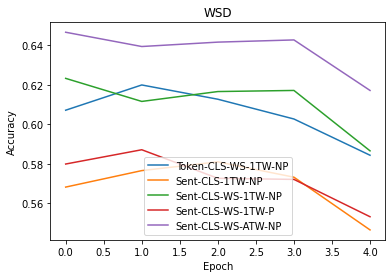

In [ ]:
accuracies_wsd_models = [accuracies_wsd_token_CLS_1TW_NP, 
                         accuracies_wsd_sent_CLS_1TW_NP,
                         accuracies_wsd_sent_CLS_WS_1TW_NP, 
                         accuracies_wsd_sent_CLS_WS_1TW_P,
                         accuracies_wsd_sent_CLS_WS_ATW_NP]

for accuracy_wsd_model, label in zip(accuracies_wsd_models, labels):
    plt.plot(accuracy_wsd_model, label=label)

plt.title('WSD')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##WiC

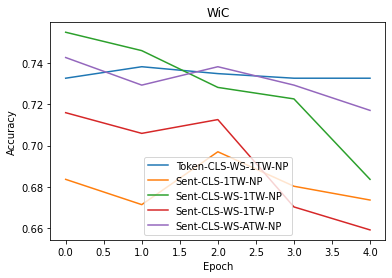

In [ ]:
accuracies_wic_models = [accuracies_wic_token_CLS_1TW_NP, 
                         accuracies_wic_sent_CLS_1TW_NP,
                         accuracies_wic_sent_CLS_WS_1TW_NP, 
                         accuracies_wic_sent_CLS_WS_1TW_P,
                         accuracies_wic_sent_CLS_WS_ATW_NP]

for accuracy_wic_model, label in zip(accuracies_wic_models, labels):
    plt.plot(accuracy_wic_model, label=label)

plt.title('WiC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###Confusion matrix

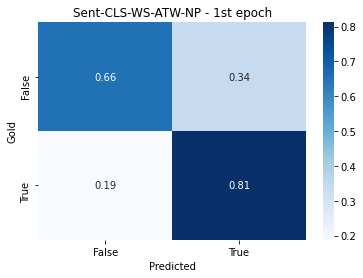

In [ ]:
# retrieving the TP, TN, FP, FN of the model Sent-CLS-WS-ATW-NP at the first epoch
TP_TN_FP_FN_sent_CLS_WS_ATW_NP_epoch_0 = TP_TN_FP_FN_sent_CLS_WS_ATW_NP[0]
                 
TP, TN, FP, FN = TP_TN_FP_FN_sent_CLS_WS_ATW_NP_epoch_0
cm_data = np.array([[TN, FP], [FN, TP]])

# normalize the confusion matrix
cm_data = cm_data.astype('float') / cm_data.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_data, annot=True, cmap='Blues', fmt='.2g', ax=ax, 
            xticklabels=['False', 'True'], yticklabels=['False', 'True'])

ax.set_title('Sent-CLS-WS-ATW-NP - 1st epoch')
plt.xlabel('Predicted')
plt.ylabel('Gold')
plt.show()

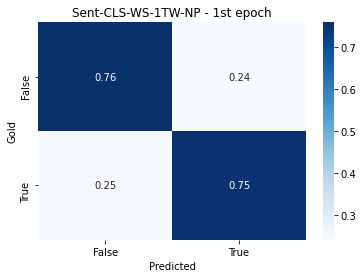

In [ ]:
# retrieving the TP, TN, FP, FN of the model Sent-CLS-WS-1TW-NP at the first epoch
TP_TN_FP_FN_sent_CLS_WS_1TW_NP_epoch_0 = TP_TN_FP_FN_sent_CLS_WS_1TW_NP[0]
                 
TP, TN, FP, FN = TP_TN_FP_FN_sent_CLS_WS_1TW_NP_epoch_0
cm_data = np.array([[TN, FP], [FN, TP]])

# normalize the confusion matrix
cm_data = cm_data.astype('float') / cm_data.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_data, annot=True, cmap='Blues', fmt='.2g', ax=ax, 
            xticklabels=['False', 'True'], yticklabels=['False', 'True'])

ax.set_title('Sent-CLS-WS-1TW-NP - 1st epoch')
plt.xlabel('Predicted')
plt.ylabel('Gold')
plt.show()